``application_{train|test}.csv``
- Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
- Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

``bureau.csv``
- Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit     (pour les clients qui ont un prêt dans notre échantillon).
- Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit     
  Bureau avant la date de la demande.

``bureau_balance.csv``
- Soldes mensuels des crédits antérieurs au bureau de crédit.
- Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-     à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique   observable pour les crédits précédents) lignes .

``POS_CASH_balance.csv``
- Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec  Home Credit.
- Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

``credit_card_balance.csv``
- Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit.
- Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

``previous_application.csv``
- Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon.
- Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

`installments_payments.csv``
- Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon.
  Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
- Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit immobilier  lié aux prêts de notre échantillon.

``HomeCredit_columns_description.csv``
- Ce fichier contient les descriptions des colonnes des différents fichiers de données.


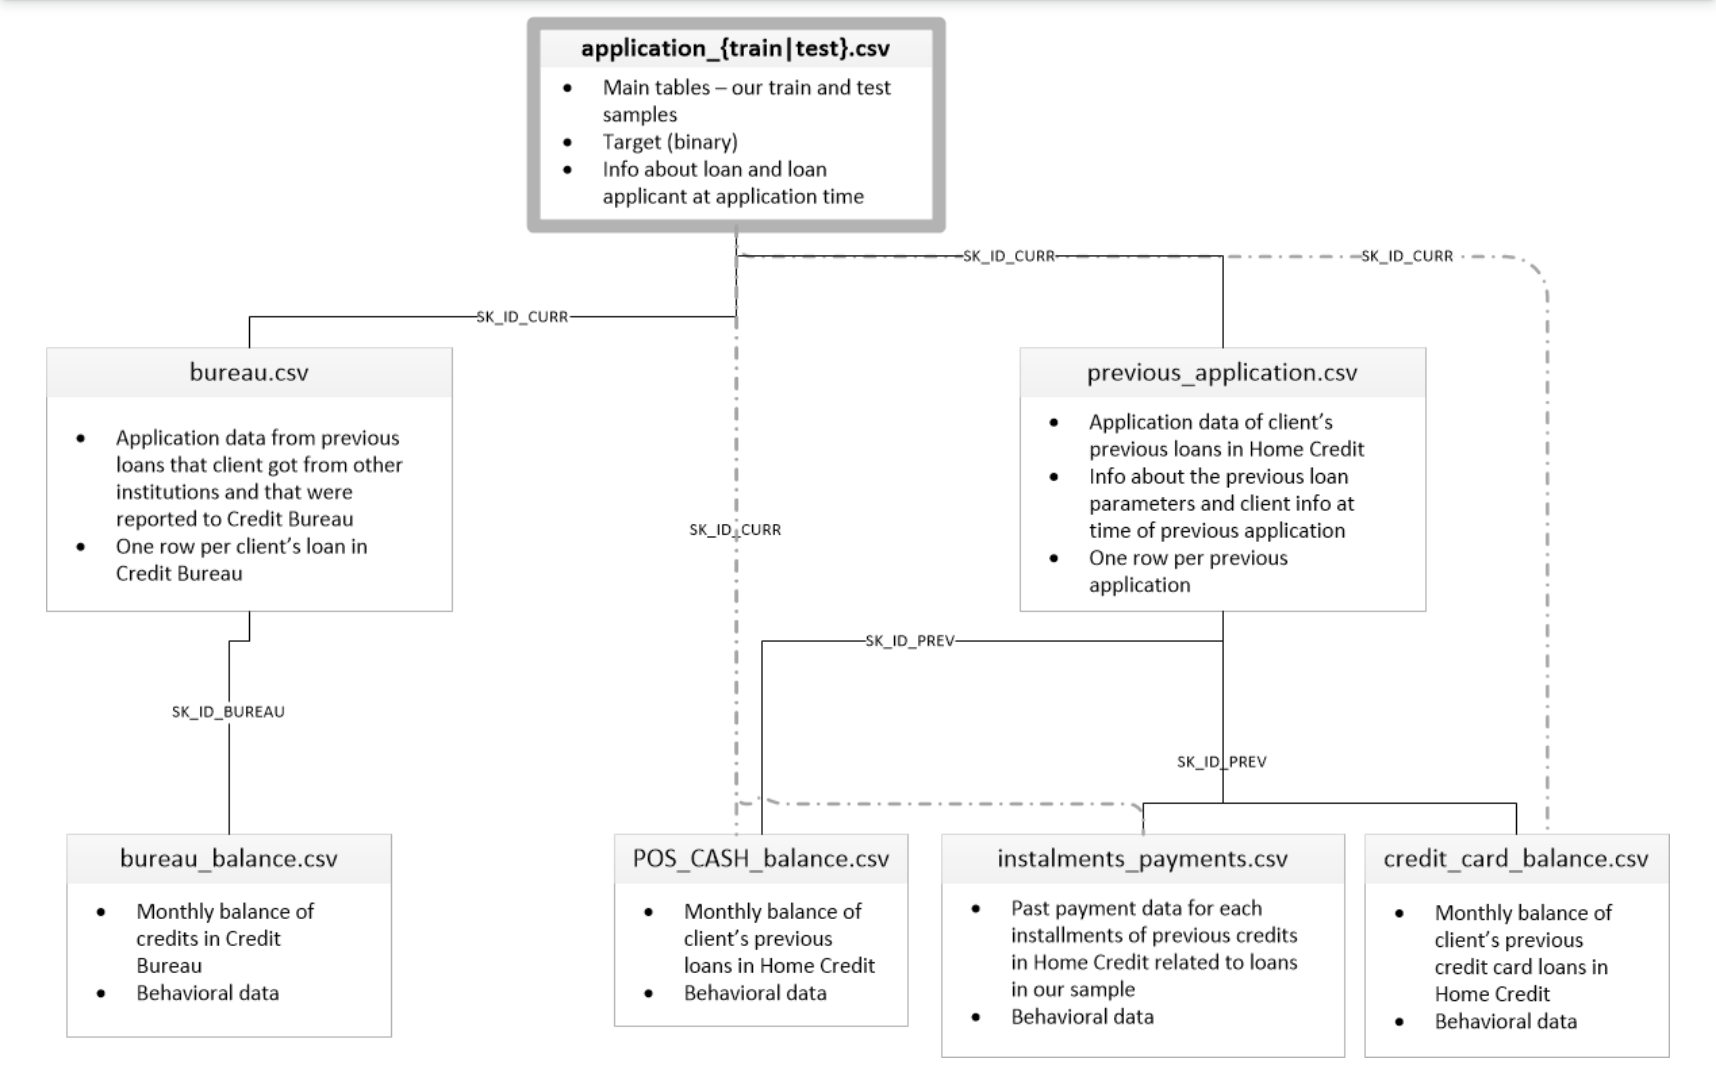

https://www.kaggle.com/c/home-credit-default-risk/data (lien de la data)

Inspiré du kernel : https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook
https://www.kaggle.com/code/danilz/merge-all-data-base-glm-vs-xgb-explained-0-763/notebook

In [18]:
import pandas as pd
import seaborn as sns
import time, pickle
import matplotlib.pyplot as plt
import numpy as np

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
#from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")

#Predictive Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

In [19]:
data = pd.read_csv ('data_df.csv')
test_df = pd.read_csv ('data_test.csv')
train_df = pd.read_csv ('data_train.csv')
TARGET = pd.read_csv ('TARGET.csv')

In [20]:
train_df = train_df.select_dtypes(include='int64').astype('int')
test_df = test_df.select_dtypes(include='int64').astype('int')


In [21]:
#del data['Unnamed: 0']
del train_df['Unnamed: 0']
del test_df['Unnamed: 0']
#del TARGET['Unnamed: 0']

In [22]:
del TARGET['Unnamed: 0']

In [23]:
print('Shape train:' ,train_df.shape )
print('Shape test :' ,test_df.shape )
print('Shape data :' ,data.shape )
print('Shape TARGET :' ,TARGET.shape )

Shape train: (307511, 310)
Shape test : (48744, 310)
Shape data : (356255, 194)
Shape TARGET : (307511, 1)


In [24]:
test_df.dtypes

SK_ID_CURR                         int32
NAME_CONTRACT_TYPE                 int32
FLAG_OWN_CAR                       int32
FLAG_OWN_REALTY                    int32
CNT_CHILDREN                       int32
                                   ...  
WALLSMATERIAL_MODE_Panel           int32
WALLSMATERIAL_MODE_Stone, brick    int32
WALLSMATERIAL_MODE_Wooden          int32
EMERGENCYSTATE_MODE_No             int32
EMERGENCYSTATE_MODE_Yes            int32
Length: 310, dtype: object

## Sépération du jeu d'entrainement en entrainement puis validation

In [25]:
X_train, X_test, y_train, y_test = train_test_split(train_df.values, TARGET.values, test_size=0.3, random_state=42)


## Oversampling Data Using SMOTE
### Equilibrage

In [26]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))



Label 1, Before using SMOTE: [17412] 
Label 0, Before using SMOTE: [197845] 


In [27]:
%%time
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)

Wall time: 8.9 s


In [28]:
print("Label 1, After using SMOTE: {}".format(sum(y_train==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train==0)))

Label 1, After using SMOTE: 197845
Label 0, After using SMOTE: 197845


### Les Modeles de predictions

- Light Gradient Boosted Machine (LightGBM) est une bibliothèque open source qui fournit une implémentation efficace et efficiente de l'algorithme d'amplification de gradient.LightGBM est un algorithme  d'apprentissage automatique pour la modélisation prédictive de régression et de classification.

L'élimination récursive de caractéristiques (RFE) est une méthode de sélection de caractéristiques qui adapte un modèle et supprime la caractéristique (ou les caractéristiques) la plus faible jusqu'à ce que le nombre spécifié de caractéristiques soit atteint. Les entités sont classées par les attributs coef_ ou feature_importances_ du modèle, et en éliminant de manière récursive un petit nombre d'entités par boucle, RFE tente d'éliminer les dépendances et la colinéarité qui peuvent exister dans le modèle.

## Modelisation sans Grid Search 

In [29]:
  models = [
          #Ensemble methods
          DummyClassifier(),
          LogisticRegression(),
          RandomForestClassifier(),
          LGBMClassifier(),
          XGBClassifier()
          ]


In [30]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }
          
    return output

In [31]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)



Wall time: 6min 27s


In [32]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
2,RandomForestClassifier,0.584911,0.868569,0.113136,0.092945,0.102051,274.638013
3,LGBMClassifier,0.57899,0.878932,0.125747,0.085121,0.10152,3.663858
4,XGBClassifier,0.575312,0.864656,0.125609,0.114798,0.119961,94.470354
1,LogisticRegression,0.570089,0.892948,0.124199,0.054904,0.076146,14.577188
0,DummyClassifier,0.5,0.919646,0.0,0.0,0.0,0.200773


In [33]:
base_model_index = base_models.copy()

In [34]:
base_model_index.set_index('Model', inplace = True)

In [35]:
base_model_index

,AUC,Accuracy,Precision,Recall,F1,Time
Model,,,,,,
RandomForestClassifier,0.584911,0.868569,0.113136,0.092945,0.102051,274.638013
LGBMClassifier,0.57899,0.878932,0.125747,0.085121,0.10152,3.663858
XGBClassifier,0.575312,0.864656,0.125609,0.114798,0.119961,94.470354
LogisticRegression,0.570089,0.892948,0.124199,0.054904,0.076146,14.577188
DummyClassifier,0.5,0.919646,0.0,0.0,0.0,0.200773


L'aire sous la courbe ROC (ou Area Under the Curve, AUC) peut être interprétée comme la probabilité que, parmi deux sujets choisis au hasard, un malade et un non-malade, la valeur du marqueur soit plus élevée pour le malade que pour le non-malade. Par conséquent, une AUC de 0,5 (50%) indique que le marqueur est non-informatif. Une augmentation de l'AUC indique une amélioration des capacités discriminatoires, avec un maximum de 1,0 (100%).

Text(0.5, 1.0, 'Metrique : Precision')

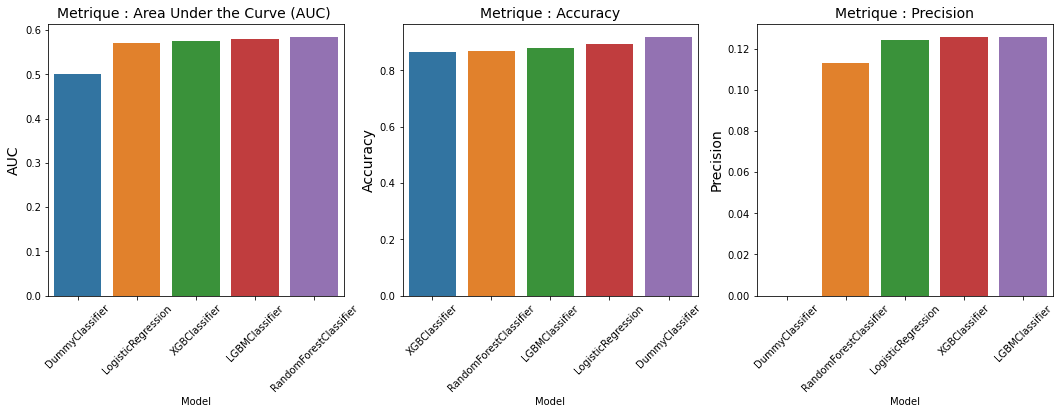

In [36]:
fig = plt.figure(1, figsize=(18, 5))

plt.subplot(131)
base_model_index = base_model_index.sort_values(by=['AUC'])
sns.barplot(x = base_model_index.index,y = base_model_index["AUC"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("AUC",fontsize=14)
plt.title("Metrique : Area Under the Curve (AUC) ", fontsize=14)


plt.subplot(132)
base_model_index = base_model_index.sort_values(by=['Accuracy'])
sns.barplot(x = base_model_index.index,y = base_model_index["Accuracy"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Accuracy",fontsize=14)
plt.title("Metrique : Accuracy", fontsize=14)

plt.subplot(133)
base_model_index = base_model_index.sort_values(by=['Precision'])
sns.barplot(x = base_model_index.index,y = base_model_index["Precision"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Precision",fontsize=14)
plt.title("Metrique : Precision", fontsize=14)

Text(0.5, 1.0, 'Le temps: Time')

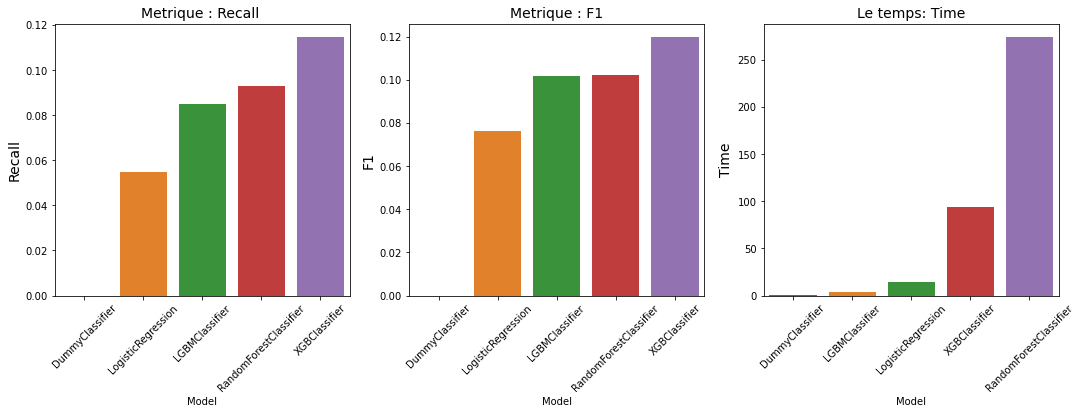

In [37]:
fig = plt.figure(1, figsize=(18, 5))

plt.subplot(131)
base_model_index = base_model_index.sort_values(by=['Recall'])
sns.barplot(x = base_model_index.index,y = base_model_index["Recall"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Recall",fontsize=14)
plt.title("Metrique : Recall ", fontsize=14)


plt.subplot(132)
base_model_index = base_model_index.sort_values(by=['F1'])
sns.barplot(x = base_model_index.index,y = base_model_index["F1"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("F1",fontsize=14)
plt.title("Metrique : F1", fontsize=14)


plt.subplot(133)
base_model_index = base_model_index.sort_values(by=['Time'])
sns.barplot(x = base_model_index.index,y = base_model_index["Time"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Time",fontsize=14)
plt.title("Le temps: Time", fontsize=14)

## Modelisation avec Grid Search 
### Hyperparameters tunning 

In [38]:
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

def cross_validation(x, y, model):
    result= cross_val_score(model, x, y, cv=kfold, scoring="roc_auc", n_jobs=-1)
    print("Score: %f" % result.mean())

In [39]:
def RndSrch_Tune(model, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='roc_auc', cv = kfold, n_jobs=-1, random_state=100)
    clf.fit(X, y)
    print("Le meilleur score est :" , clf.best_score_)
    print("Le meilleur estimateur est :" , clf.best_estimator_)
    print("Le meilleur paramètre est :" , clf.best_params_)
    return (clf.best_score_)

### LGBMClassifier

In [40]:
# Value of hyperparameters for random search

param_lgb = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
              'num_leaves':range(10,100,10),
              'min_child_samples':range(500,1000,100),
              'reg_alpha':[0.1,0.01,0.2,0.3],
              'reg_lambda':[0.1,0.01,0.2,0.3],
             'n_estimators':range(50,300,50),
              'max_bin': range(500,1500,100)}

RndSrch_Tune(LGBMClassifier(random_state = 100, n_jobs=-1, class_weight = 'balanced'), 
              X_train, y_train, param_lgb)

Le meilleur score est : 0.9510936138147097
Le meilleur estimateur est : LGBMClassifier(class_weight='balanced', learning_rate=0.2, max_bin=1000,
               min_child_samples=800, n_estimators=150, num_leaves=60,
               random_state=100, reg_alpha=0.01, reg_lambda=0.01)
Le meilleur paramètre est : {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'num_leaves': 60, 'n_estimators': 150, 'min_child_samples': 800, 'max_bin': 1000, 'learning_rate': 0.2}


0.9510936138147097

In [41]:
lgb = LGBMClassifier(**{'class_weight' : 'balanced',
                        'learning_rate' : 0.2,
                        'max_bin' : 1000,
                        'min_child_samples' : 800,
                        'n_estimators' : 150,
                        'num_leaves' : 60,
                        'random_state' : 100,
                        'reg_alpha' : 0.01,
                        'reg_lambda' : 0.01,
                        'reg_lambda': 0.01, 
                        'reg_alpha': 0.01, 
                        'num_leaves': 60, 
                        'n_estimators': 150,
                        'min_child_samples': 800,
                        'max_bin': 1000, 
                        'learning_rate': 0.2 })

scores = cross_validation(X_train, y_train, lgb)
print(scores)

Score: 0.951094
None


### XGBClassifier

In [42]:
counter = Counter(y_train)
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.000


In [43]:
# Value of hyperparameters for random search

param_xgbc = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
              'subsample':[1,0.5,0.2,0.1],
              'max_depth' : range(2,11,1),
              'n_estimators':range(50,300,50)}

RndSrch_Tune(XGBClassifier(random_state = 100, n_jobs=-1, scale_pos_weight=estimate), 
              X_train, y_train, param_xgbc)

Le meilleur score est : 0.9430956532068351
Le meilleur estimateur est : XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=250,
              n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=100, reg_alpha=0, reg_lambda=1, ...)
Le meilleur paramètre est : {'subsample': 0.1, 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.1}


0.9430956532068351

In [46]:
xgbc = XGBClassifier(**{'subsample': 0.1,
                        'n_estimators': 250, 
                        'max_depth': 5,
                        'learning_rate': 0.1
                        })

scores_xgbc = cross_validation(X_train, y_train, xgbc)
print(scores_xgbc)

Score: 0.942479
None


### LogisticRegression

In [47]:
# Value of hyperparameters for random search

param_clr = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

RndSrch_Tune(LogisticRegression(C = 0.0001, max_iter=100), X_train, y_train, param_clr)

Le meilleur score est : 0.9483368953382806
Le meilleur estimateur est : LogisticRegression(C=10.0)
Le meilleur paramètre est : {'penalty': 'l2', 'C': 10.0}


0.9483368953382806

In [48]:
clr = LogisticRegression(**{'penalty': 'l2', 'C': 10.0})

scores_clr = cross_validation(X_train, y_train, clr)
print(scores_clr)

Score: 0.948337
None


### RandomForestClassifier

In [50]:
# Value of hyperparameters for random search

param_rdc = {'n_estimators': [200, 500],
             'max_features': ['auto', 'sqrt', 'log2'],
             'max_depth' : [4,5,6,7,8],
             'criterion' :['gini', 'entropy']}

RndSrch_Tune(RandomForestClassifier(random_state=42), X_train, y_train, param_rdc)



Le meilleur score est : 0.7955266016933304
Le meilleur estimateur est : RandomForestClassifier(criterion='entropy', max_depth=8, max_features='log2',
                       n_estimators=500, random_state=42)
Le meilleur paramètre est : {'n_estimators': 500, 'max_features': 'log2', 'max_depth': 8, 'criterion': 'entropy'}


0.7955266016933304

In [53]:
rdc = RandomForestClassifier(**{'n_estimators': 500, 
                                'max_features': 'log2', 
                                'max_depth': 8,
                                'criterion': 'entropy'})

scores_rdc = cross_validation(X_train, y_train, rdc)
print(scores_rdc)

Score: 0.795020
None


### DummyClassifier

In [57]:
# Value of hyperparameters for random search

param_dummyc = { 'strategy':["most_frequent", "prior", "uniform"]}

RndSrch_Tune(DummyClassifier(), X_train, y_train, param_dummyc)



Le meilleur score est : 0.5
Le meilleur estimateur est : DummyClassifier(strategy='most_frequent')
Le meilleur paramètre est : {'strategy': 'most_frequent'}


0.5

In [58]:
dummyc  = DummyClassifier(**{'strategy': 'most_frequent'})

scores_dummyc = cross_validation(X_train, y_train, dummyc)
print(scores_dummyc)

Score: 0.500000
None


In [61]:
  models_gridseach = [
          #Ensemble methods
          DummyClassifier(**{'strategy': 'most_frequent'}),
          LogisticRegression(**{'penalty': 'l2', 'C': 10.0}),
          RandomForestClassifier(**{'n_estimators': 500, 
                                'max_features': 'log2', 
                                'max_depth': 8,
                                'criterion': 'entropy'}),
          LGBMClassifier(**{'class_weight' : 'balanced',
                        'learning_rate' : 0.2,
                        'max_bin' : 1000,
                        'min_child_samples' : 800,
                        'n_estimators' : 150,
                        'num_leaves' : 60,
                        'random_state' : 100,
                        'reg_alpha' : 0.01,
                        'reg_lambda' : 0.01,
                        'reg_lambda': 0.01, 
                        'reg_alpha': 0.01, 
                        'num_leaves': 60, 
                        'n_estimators': 150,
                        'min_child_samples': 800,
                        'max_bin': 1000, 
                        'learning_rate': 0.2} ),
          XGBClassifier(**{'subsample': 0.1,
                        'n_estimators': 250, 
                        'max_depth': 5,
                        'learning_rate': 0.1})
          ]


In [65]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models_gridseach:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models_gridsearch = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models_gridsearch.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models_gridsearch.sort_values('AUC', ascending=False, inplace=True)


Wall time: 9min 56s


In [66]:
base_models_gridsearch

,Model,AUC,Accuracy,Precision,Recall,F1,Time
2,RandomForestClassifier,0.615813,0.669239,0.117115,0.476595,0.188026,295.416406
4,XGBClassifier,0.581248,0.838836,0.125189,0.167948,0.14345,246.863605
3,LGBMClassifier,0.572551,0.874282,0.103918,0.074059,0.086484,10.795304
1,LogisticRegression,0.569296,0.892287,0.123957,0.056118,0.077259,42.726259
0,DummyClassifier,0.5,0.919646,0.0,0.0,0.0,0.272702


In [67]:
base_models_gridsearch_index = base_models_gridsearch.copy()

In [68]:
base_models_gridsearch_index.set_index('Model', inplace = True)

In [69]:
base_models_gridsearch_index

,AUC,Accuracy,Precision,Recall,F1,Time
Model,,,,,,
RandomForestClassifier,0.615813,0.669239,0.117115,0.476595,0.188026,295.416406
XGBClassifier,0.581248,0.838836,0.125189,0.167948,0.14345,246.863605
LGBMClassifier,0.572551,0.874282,0.103918,0.074059,0.086484,10.795304
LogisticRegression,0.569296,0.892287,0.123957,0.056118,0.077259,42.726259
DummyClassifier,0.5,0.919646,0.0,0.0,0.0,0.272702


Le modèle est bon dès lors que la valeur de l'AUC est supérieure à 0.7.
Un modèle bien discriminant doit avoir une AUC entre 0.87 et 0.9. 
Un modèle ayant une AUC supérieure à 0.9 est excellent
Dans nombre notre cas le meuilleur modèle parmi les autres est: ``RandomForestClassifier`` avec une valeur AUC = 0.6 (modèle moyennement bon


L'accuracy est une métrique de performance qui évalue la capacité d'un modèle de classification à bien prédire à la fois les individus positifs et les individus négatifs.
L’indicateur le plus simple est l’accuracy : il indique le pourcentage de bonnes prédictions. C’est un très bon indicateur parce qu’il est très simple à comprendre.

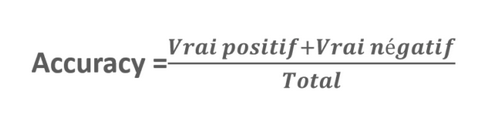

Pour compléter l’accuracy, on calcule également le recall : il se concentre uniquement sur les clients qui ont réellement résilié et donne une indication sur la part de faux négatifs. Les faux négatifs ce sont les clients qui résilient mais qui ne sont pas détectés par le score. Concrètement ce sont des clients que vous ne détectez pas et pour lesquels vous ne pourrez pas agir pour éviter leur départ.

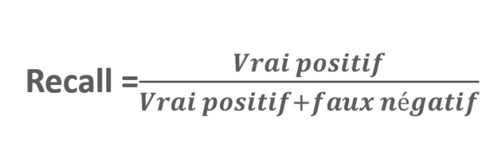

Enfin, un 3ème indicateur vient compléter l’accuracy et le recall, c’est la precision : il se concentre uniquement sur les clients pour lesquels le modèle a prédit une résiliation et donne une indication sur les faux positifs. Les faux positifs ce sont les clients pour lesquels le score a prédit une résiliation mais qui sont restés abonnés. C’est à dire que pour ces clients, vous engagerez surement des actions marketing pour les fidéliser mais ces actions n’étaient pas nécessaires puisqu’ils n’allaient pas résilier. Il faut limiter les faux positifs pour réduire le coût des campagnes.

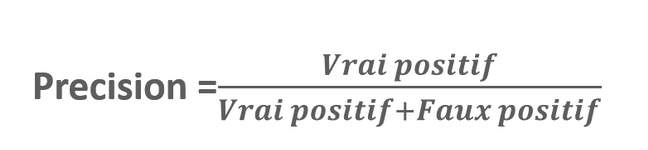

La matrice de confusion à elle seule donne des informations vraiment intéressantes. On peut identifier quelles sont les forces et les faiblesses de nos algorithmes.

L’accuracy, le recall et la precision sont à utiliser ensemble pour donner une vision complète de la performance. On cherche à avoir des valeurs le plus proche possible de 100% pour les 3 indicateurs. Selon les cas, on choisira parfois de maximiser le recall plutôt que la precision ou vice versa. Cela dépend du projet. 

Text(0.5, 1.0, 'Metrique : Precision')

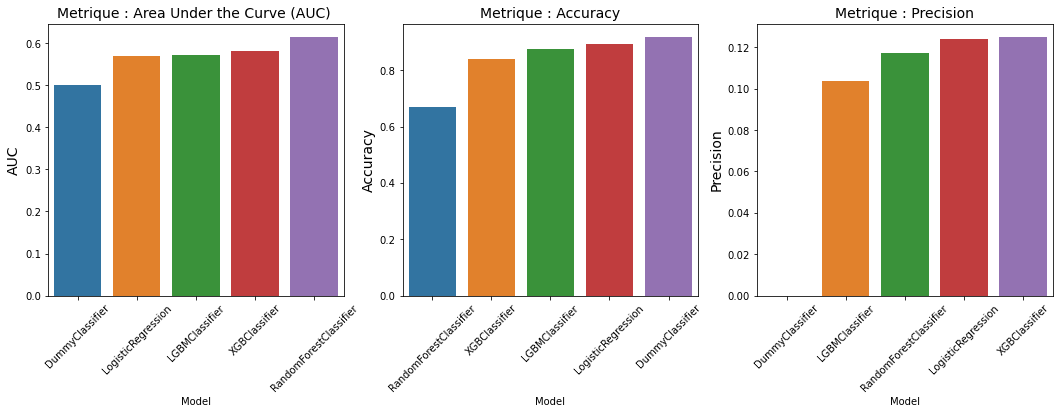

In [70]:
fig = plt.figure(1, figsize=(18, 5))

plt.subplot(131)
base_models_gridsearch_index = base_models_gridsearch_index.sort_values(by=['AUC'])
sns.barplot(x = base_models_gridsearch_index.index,y = base_models_gridsearch_index["AUC"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("AUC",fontsize=14)
plt.title("Metrique : Area Under the Curve (AUC) ", fontsize=14)


plt.subplot(132)
base_models_gridsearch_index = base_models_gridsearch_index.sort_values(by=['Accuracy'])
sns.barplot(x = base_models_gridsearch_index.index,y = base_models_gridsearch_index["Accuracy"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Accuracy",fontsize=14)
plt.title("Metrique : Accuracy", fontsize=14)

plt.subplot(133)
base_models_gridsearch_index = base_models_gridsearch_index.sort_values(by=['Precision'])
sns.barplot(x = base_models_gridsearch_index.index,y = base_models_gridsearch_index["Precision"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Precision",fontsize=14)
plt.title("Metrique : Precision", fontsize=14)

Text(0.5, 1.0, 'Le temps: Time')

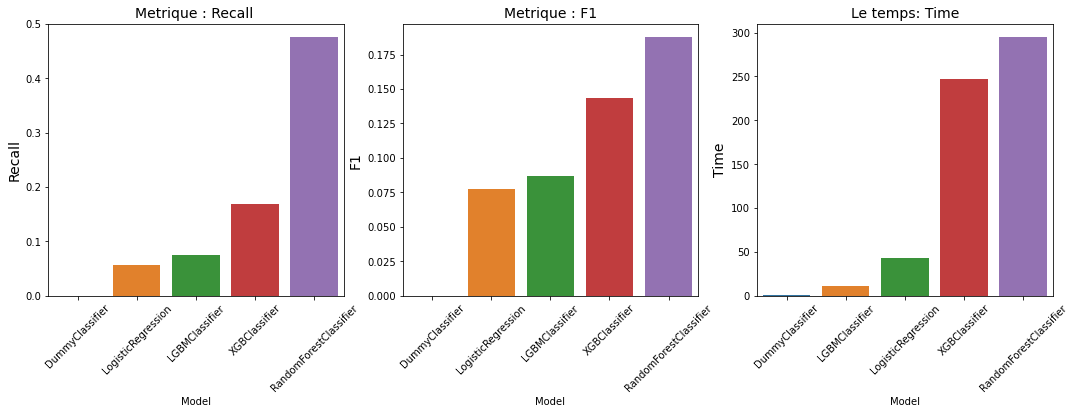

In [71]:
fig = plt.figure(1, figsize=(18, 5))

plt.subplot(131)
base_models_gridsearch_index = base_models_gridsearch_index.sort_values(by=['Recall'])
sns.barplot(x = base_models_gridsearch_index.index,y = base_models_gridsearch_index["Recall"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Recall",fontsize=14)
plt.title("Metrique : Recall ", fontsize=14)


plt.subplot(132)
base_models_gridsearch_index = base_models_gridsearch_index.sort_values(by=['F1'])
sns.barplot(x = base_models_gridsearch_index.index,y = base_models_gridsearch_index["F1"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("F1",fontsize=14)
plt.title("Metrique : F1", fontsize=14)


plt.subplot(133)
base_models_gridsearch_index = base_models_gridsearch_index.sort_values(by=['Time'])
sns.barplot(x = base_models_gridsearch_index.index,y = base_models_gridsearch_index["Time"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Time",fontsize=14)
plt.title("Le temps: Time", fontsize=14)

### Evaluation 

In [74]:
classifiers = [clr,lgb, xgbc,rdc,dummyc]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for cls in classifiers:
    model = cls.fit(X_train, y_train,)
    yproba = model.predict_proba(X_train)[::,1]
    
    fpr, tpr, _ = roc_curve(y_train,  yproba)
    auc = roc_auc_score(y_train, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

In [76]:
result_table

,fpr,tpr,auc
classifiers,,,
LogisticRegression,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 5.054461826177058e-06, 3.538123278323940...",0.948556
LGBMClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 2.021784730470823e-05, 2.527230913088529...",0.956526
XGBClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 5.054461826177058e-06, 2.021784730470823...",0.944382
RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 2.527230913088529e-05, 7.076246556647881...",0.796810
DummyClassifier,"[0.0, 1.0]","[0.0, 1.0]",0.500000


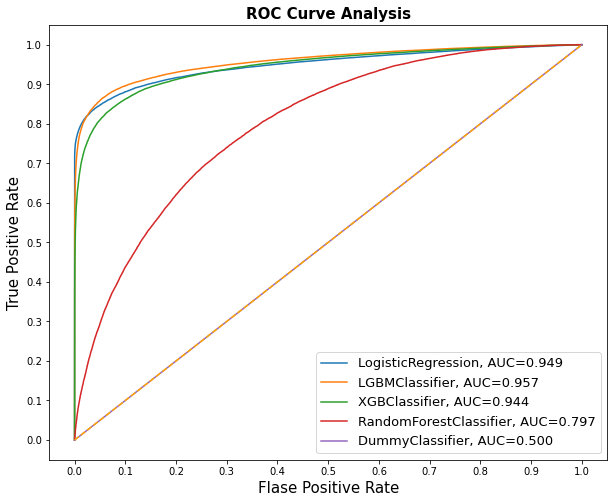

In [75]:
fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc'])
             )
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
#plt.show()

### The best model is LGBMClassifier

In [77]:
lgb.fit(X_train, y_train)
y_pred_LGB = lgb.predict(X_train)
y_pred_LGB_test = lgb.predict(test_df)

In [78]:
output = pd.DataFrame({'SK_ID_CURR': test_df.SK_ID_CURR, 
                       'TARGET': lgb.predict_proba(test_df)[:,1]})
output.head()

,SK_ID_CURR,TARGET
0,0,0.154802
1,0,0.366842
2,0,0.407839
3,0,0.322637
4,0,0.625025
